In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import keras
from keras.models import load_model
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten
from keras.models import Sequential
from keras.layers import BatchNormalization, Dropout
from keras.utils import np_utils
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
model = load_model("/content/gdrive/MyDrive/Colab_Notebooks/ACC(0.9942)-ValACC(0.9218).h5")
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 128)      

In [ ]:
scaler = StandardScaler()
(X_train, y_train), (X_test, y_test) = keras.datasets.cifar10.load_data()
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((50000, 32, 32, 3), (50000, 1), (10000, 32, 32, 3), (10000, 1))

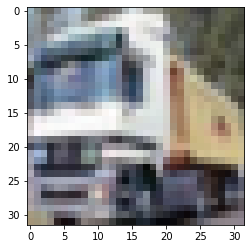

In [ ]:
plt.imshow(X_train[1])
plt.show()

In [ ]:
loss_object = tf.keras.losses.CategoricalCrossentropy()

def create_FGSM(input_image, input_label):
  with tf.GradientTape() as tape:
    tape.watch(input_image)
    prediction = model(input_image)
    loss = loss_object(input_label, prediction)

  # 입력 이미지에 대한 손실 함수의 기울기를 구합니다.
  gradient = tape.gradient(loss, input_image)
  # 왜곡을 생성하기 위해 그래디언트의 부호를 구합니다.
  signed_grad = tf.sign(gradient)
  return signed_grad

In [ ]:
def preprocess(image):
  image = tf.cast(image, tf.float32)
  image = image/255
  image = tf.image.resize(image, (32, 32))
  image = image[None, ...]
  return image

In [ ]:
y_train[0]
tf.convert_to_tensor(np_utils.to_categorical(y_train[0], 10))

<tf.Tensor: shape=(1, 10), dtype=float32, numpy=array([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]], dtype=float32)>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


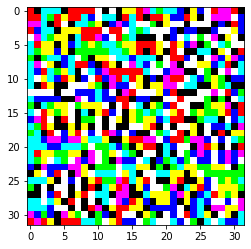

In [ ]:
image = preprocess(X_train[1])
label = tf.convert_to_tensor(np_utils.to_categorical(y_train[1], 10))

perturbations = create_FGSM(image, label)
plt.imshow(perturbations[0])

In [ ]:
perturbations.shape

TensorShape([1, 32, 32, 3])

In [ ]:
image.shape

TensorShape([1, 32, 32, 3])

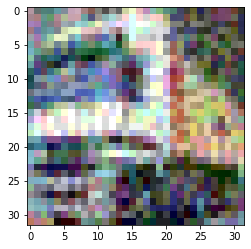

In [ ]:
adv_x = image + 0.1*perturbations
adv_x = tf.clip_by_value(adv_x, 0, 1)
plt.imshow(adv_x[0])
plt.show()